# Supernova Classification with Machine Learning
## Dr. Michelle Lochner
*ESAC Data Analysis and Statistics Workshop 2017*

This tutorial aims to give an introduction to the principles of basic machine learning, using an example problem of supernova classification. 

This is based on: <br>
["Photometric Supernova Classification With Machine Learning"](https://arxiv.org/abs/1603.00882), Lochner et al. (2016)  <br>

And [this](https://github.com/MichelleLochner/ml-tutorial) even simpler tutorial.

*Further reading (see notes for more detailed references)*
- [sncosmo](https://sncosmo.readthedocs.io)
- [scikit-learn](http://scikit-learn.org/)
- The supernova classification [challenge](https://arxiv.org/abs/1001.5210) and [results](https://arxiv.org/abs/1008.1024)
- [SALT2 template fitting](https://arxiv.org/abs/astro-ph/0701828)

## Background

Supernova classification is a hot topic in astronomy at the moment. It's well known that there are several types of supernovae and to a cosmologist, only one of them is really useful: a Ia. Astrophysicists studying supernovae also need to know if they're dealing with a core collapse or Ia supernova. The problem is, traditionally the only way to truly accurately type a supernova is with a spectrum. In current and future surveys such as DES and LSST, there will be simply too many supernovae detected to follow them up spectroscopically. If we want to make use of this large dataset of photometric supernovae, we need a way to automatically classify them based on photometry alone (that is the light curve of the supernova in several different colour filters).

Since we will generally have a small training set of supernovae that have been spectroscopically typed, this is a great problem for supervised machine learning.

In this tutorial, you will go through the same procedure as you would for any supervised machine learning problem. You will first extract meaningful, scientifically driven features from raw data. You will decide how to split your data into training, validation and test sets. And finally, you will choose a machine learning algorithm to classify the supernovae and evaluate the results. 

**Data**<br>
The data we will use is the same as in Lochner et al. (2016), a subset of simulations from the Photometric Supernova Classification Challenge (SPCC, Kessler et al. 2010). The data consists of light curves (brightness as a function of time) in four different filter bands, with metadata including the type and the redshift. I have provided a subset of the data in an astropy table format.

**Features**<br>
The features we will use will be from a SALT-II model fit (Guy et al. 2007), which is an empirically determined model (based on spectral time series data) with 5 parameters:<br>
z - supernova redshift<br>
t0 - time of peak flux<br>
x0 - related to amplitude of the supernova<br>
x1 - related to the stretch of the supernova<br>
c - related to the colour of the supernova<br>

The package `sncosmo` can be used to fit these features to each light curve in the dataset. We expect it to fit well for Ia's and not so well for non-Ia's. 

**Classification**<br>
We'll use `sklearn` for classification. It will be up to you to apply the concepts covered in the lecture, including training/test splits, cross-validation, algorithm choice and measuring performance. 

In [1]:
from __future__ import division, print_function

import time
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

# Used to normalise features
from sklearn.preprocessing import StandardScaler 
# Used for hyperparameter optimisation and to avoid overfitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Some example algorithms you can try using (sklearn has many more)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
%matplotlib inline

# Section 1: Setup

### How to read in a supernova light curve as an astropy table

Unzip the data (if not already unzipped)

In [2]:
data_root = os.path.join('data','')

if not os.path.exists(data_root):
    subprocess.call(['unzip', 'data.zip'])

I've saved the supernova light curves in a format that `sncosmo` can read: an astropy table. The cell below reads in a single object's data and displays the table. 

The columns are: <br>
`mjd`: Time in days since the first observation of the supernova <br>
`filter`: Which filter band the observation is in (i.e. which colour)<br>
`flux`: The flux (brightness) in that band<br>
`flux_error`: Uncertainty on the flux due to instrumental noise<br>
`zp`: Zero point (The magnitude the flux is calibrated to)<br>
`zpsys`: The system used to calibrate the flux

Here's what a light curve looks like in astropy table format:

In [3]:
salt2_param=np.genfromtxt('salt2_fit_train_sample.txt', names=True, dtype=None)

# Section 2: Feature extraction

In [4]:
def fit_supernova(lc):
    """
    Small function to fit a light curve with the SALT2 model, using sncosmo and iminuit.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    z, t0, x0, x1, c
        Best-fitting parameters of the model
    """
    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)

    return res[0].parameters

In [5]:
#df_labels=['M_%.3f'%mjd for mjd in mjds_selected]+['filter','lc']
#df = pd.DataFrame(columns=df_labels)

Let's fit one of these light curves:

sncosmo can make a nice plot to show if the fit works well

**I've already extracted features for you (because it takes a little while) in a file called "salt2_features.txt"**<br>
Load the features into a numpy array. There's another file called "labels.txt" which has the true label for each object (what we're trying to predict). The labels are:

1 - Ia<br>
2 - II<br>
3 - Ibc<br>

In [6]:
type_results=np.genfromtxt('labels.txt', names=True, dtype=None)

# Section 3: Classification

In [7]:
sn_machine='/Users/mariavincenzi/PhD/SNChallenge/supernova-machine/'

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import time

import sys
import os
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
max_ml_algorithms_file=sn_machine+'max_ml_algorithms.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_ml_algorithms_file)))
import max_ml_algorithms as ml_algorithms#, max_tools as tools
max_tools_file=sn_machine+'max_tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_tools_file)))
import max_tools as tools

/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This 

In [8]:
#feats = np.genfromtxt(sn_machine+'sncosmo_des_fit.txt', dtype='str', comments='#')
#print (np.sort(feats[:,0]))
#print (len(np.sort(feats[:,0])))

In [9]:
mypath='/Users/mariavincenzi/PhD/SNChallenge/DES_BLIND+HOSTZ/'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if (isfile(join(mypath, f)))&(f[-3:]=='DAT')]

In [10]:
len(onlyfiles)

18321

In [11]:
def prepare_data4ml_algorithms(feats_file, which_feat, which_feat_err):
    f = np.array(feats_file[:, which_feat], dtype='float')
    err = np.array(feats_file[:, which_feat_err], dtype='float')
    types = np.array(feats_file[:, 1], dtype='int')

    X = f[types!=-9, :]
    Y = types[types!=-9]
    X_err = err[types!=-9, :]

    X_scaled, X_err_scaled, mean,std= tools.scale_data_with_errors(X, X_err)
    X_combined = np.concatenate((X_scaled, X_err_scaled), axis=1)

    #Combine classes into Ia (Y=1), II (Y=2), and Ib and Ic (Y=3)
    Y[(Y==21) | (Y==22) | (Y==23)]=2
    Y[(Y==32) | (Y==33)]=3
    
    return X_combined, Y, X_scaled.shape[1], mean, std


In [12]:
def run_ml_plot(X_combined, Y, Shape):
    #Preallocate results table for multiple runs
    #NOTE I'M HARD CODING THE NUMBER OF CLASSIFIERS AND PERFORMANCE
    #CRITERION HERE
    N_runs = 1
    N_classifiers = 7
    N_scores = 3
    results = -999*np.ones([N_classifiers, N_scores, N_runs])
    thresholds = -999*np.ones([N_classifiers, N_scores-1, N_runs])

    #Run classifiers and return AUC, FoM and F1 for each
    for run_counter in np.arange(N_runs):
       
        X_train_combined, X_test_combined, Y_train, Y_test = train_test_split(
        X_combined, Y, test_size=0.5, random_state=np.random.randint(100))
        
        #Seperate features and errors again
        X_train = X_train_combined[:, :Shape]
        X_train_err = X_train_combined[:, Shape:]
        X_test = X_test_combined[:, :Shape]
        X_test_err = X_test_combined[:, Shape:]
        
        print (X_train.shape)
        print (X_test.shape)

        #Run classifiers
        results_temp, thresholds_temp, P_RF_test, P_RF_train = tools.run_ml(X_train, Y_train, X_test, Y_test, X_train_err, X_test_err)
        results[:, :, run_counter] = results_temp
        thresholds[:, :, run_counter] = thresholds_temp
        
        #Clean up a bit
        del results_temp, thresholds_temp, X_train_combined, X_test_combined
        
    return results, thresholds, P_RF_test, P_RF_train, X_test, Y_test, X_train, Y_train


In [13]:
start = time.time()

feats = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete.txt', dtype='str', comments='#')
feats_log10 = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete_log10x0_mb.txt',\
                            dtype='str', comments='#')


#Features
feat_noz=[8,10,12,14]
feat_noz_err=[9,11,13,15]

feat_S2z=[6,8,10,12,14]
feat_S2z_err=[7,9,11,13,15]

feat_zph=[16,18,20,22,24]
feat_zph_err=[17,19,21,23,25]

feat_zsp=[26,28,30,32,34]
feat_zsp_err=[27,29,31,33,35]


In [14]:
print (feats[0][feat_noz])
print (feats[0][feat_S2z])
print (feats[0][feat_zph])
print (feats[0][feat_zsp])

['26.235994' '0.000010' '1.093366' '-0.134664']
['0.712485' '26.235994' '0.000010' '1.093366' '-0.134664']
['0.505194' '24.823965' '0.000010' '1.545147' '0.084966']
['0.552431' '25.276087' '0.000011' '1.544768' '0.009285']


In [29]:
def results_analysis(RES_XX, chopped_also=False):
    results, thresholds, P_RF_test, P_RF_train, X_test, Y_test, X_train, Y_train = RES_XX
    #concatenate:
    X=np.concatenate([X_test, X_train])
    Y=np.concatenate([Y_test, Y_train])
    P_RF=np.concatenate([P_RF_test, P_RF_train])

    Res_Class=np.array([1+np.argmax([P_RF[i,0], P_RF[i,1], P_RF[i,2]])\
                             for i in range(len(Y))])

    FN_Ia=((Res_Class!=1))&(Y==1)
    FP_Ia=((Res_Class==1))&(Y!=1)
    TP_Ia=((Res_Class==1))&(Y==1)
    TN_Ia=((Res_Class!=1))&(Y!=1)
    
    print ('FP', len(Y[FP_Ia]), 'FN', len(Y[FN_Ia]))
    print ('TP', len(Y[TP_Ia]), 'TN', len(Y[TN_Ia]))

    print ('########  purity: ', np.round(100.*float(len(Y[TP_Ia]))/(len(Y[FP_Ia])+len(Y[TP_Ia]))))
    print ('########  efficiency: ', np.round(100*float(len(Y[TP_Ia]))/(len(Y[FN_Ia])+len(Y[TP_Ia]))))
    
    Res_Class_chop= np.ones(len(Y))*2
    Res_Class_chop[P_RF[:,0]>0.95]= 1 
    
    FN_Ia_c=((Res_Class_chop!=1))&(Y==1)
    FP_Ia_c=((Res_Class_chop==1))&(Y!=1)
    TP_Ia_c=((Res_Class_chop==1))&(Y==1)
    TN_Ia_c=((Res_Class_chop!=1))&(Y!=1)
    print ('FP', len(Y[FP_Ia_c]), 'FN', len(Y[FN_Ia_c]))
    print ('TP', len(Y[TP_Ia_c]), 'TN', len(Y[TN_Ia_c]))
    
    print ('########  purity chopping: ', np.round(100.*float(len(Y[TP_Ia_c]))/(len(Y[FP_Ia_c])+len(Y[TP_Ia_c]))))
    print ('########  efficiency chopping: ', np.round(100*float(len(Y[TP_Ia_c]))/(len(Y[FN_Ia_c])+len(Y[TP_Ia_c]))))
    
    if chopped_also:
        return X, Y, FN_Ia, FP_Ia, TP_Ia, TN_Ia, FN_Ia_c, FP_Ia_c, TP_Ia_c, TN_Ia_c
    else:
        return X, Y, FN_Ia, FP_Ia, TP_Ia, TN_Ia

scale_data_with_errors [  1.49284169e+01   2.44004777e-05   4.12558356e-01  -1.08152806e-01] [  2.68990017e+01   6.97127612e-05   1.48272473e+00   2.12204299e-01]
(628, 4)
(628, 4)
KNN optimiser time taken: 0.604007959366
('FeatImp', array([ 0.24490866,  0.14899747,  0.36021149,  0.24588239]))
('FeatImp', array([ 0.2429749 ,  0.15974237,  0.33811861,  0.25916412]))
('FeatImp', array([ 0.24746306,  0.15128232,  0.35427444,  0.24698018]))
('FeatImp', array([ 0.2479515 ,  0.1620076 ,  0.33222432,  0.25781658]))
('FeatImp', array([ 0.24599144,  0.15260747,  0.3547857 ,  0.24661539]))
('FeatImp', array([ 0.24619474,  0.16312766,  0.33455619,  0.25612141]))
('FeatImp', array([ 0.24685781,  0.15239486,  0.35353167,  0.24721566]))
('FeatImp', array([ 0.2462395 ,  0.16195613,  0.33336797,  0.2584364 ]))
('FeatImp', array([ 0.2475361 ,  0.15271688,  0.3560947 ,  0.24365232]))
('FeatImp', array([ 0.24552197,  0.16220484,  0.33500347,  0.25726972]))
RF optimisier time taken: 85.8235778809
('ARGS',

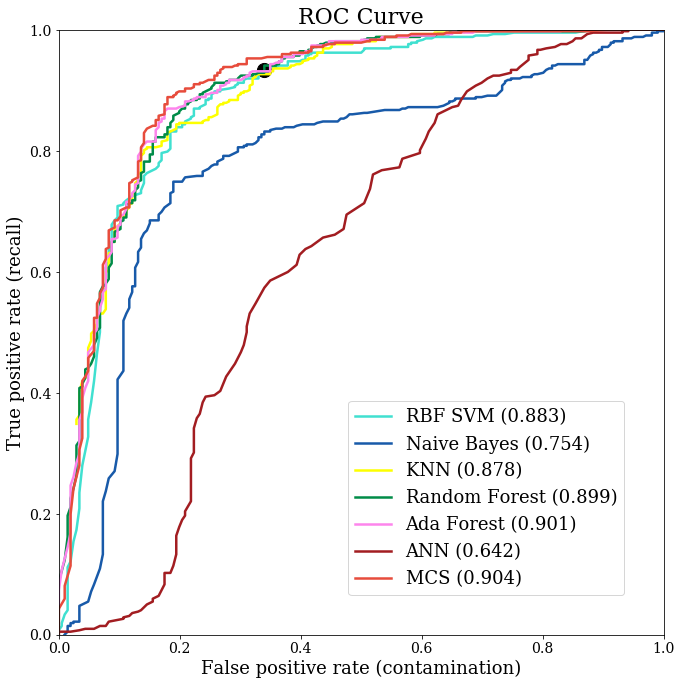

In [16]:
X_combined, Y_keys , Sh, mean_noz, std_noz= prepare_data4ml_algorithms(feats, feat_noz, feat_noz_err)
RES_noz=run_ml_plot(X_combined, Y_keys, Sh)

In [17]:
X, Y, FN_Ia, FP_Ia, TP_Ia, TN_Ia= results_analysis(RES_noz)

FP 131 FN 49
TP 830 TN 246
########  purity:  86.0
########  efficiency:  94.0
FP 16 FN 508
TP 371 TN 361
########  purity chopping:  96.0
########  efficiency chopping:  42.0


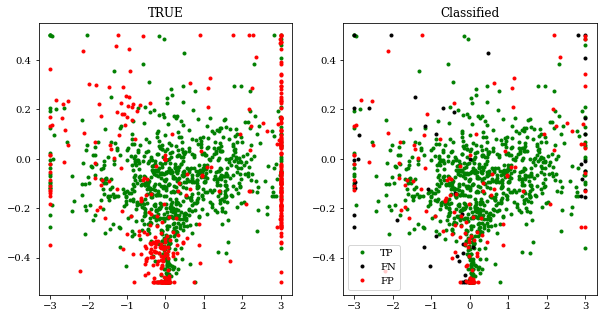

In [18]:
x1_rescaled=(X[:,2]*std_noz[2])+mean_noz[2]
c_rescaled=(X[:,3]*std_noz[3])+mean_noz[3]

fig=plt.figure(1,figsize=(10,5))
plt.subplot(121)
plt.title('TRUE')
plt.plot(x1_rescaled[Y==1], c_rescaled[Y==1], '.g')
plt.plot(x1_rescaled[Y!=1], c_rescaled[Y!=1], '.r')
plt.subplot(122)
plt.title('Classified')
plt.plot(x1_rescaled[TP_Ia], c_rescaled[TP_Ia], '.g', label='TP')
plt.plot(x1_rescaled[FN_Ia], c_rescaled[FN_Ia], '.k', label='FN')
plt.plot(x1_rescaled[FP_Ia], c_rescaled[FP_Ia], '.r', label='FP')
plt.legend(loc='best')

scale_data_with_errors [  6.65580162e-01   1.49284169e+01   2.44004777e-05   4.12558356e-01
  -1.08152806e-01] [  1.81212252e-01   2.68990017e+01   6.97127612e-05   1.48272473e+00
   2.12204299e-01]
(628, 5)
(628, 5)
KNN optimiser time taken: 0.80326795578
('FeatImp', array([ 0.13935059,  0.21339027,  0.130602  ,  0.29772607,  0.21893107]))
('FeatImp', array([ 0.15092111,  0.2121803 ,  0.13735153,  0.27822411,  0.22132295]))
('FeatImp', array([ 0.14143462,  0.21355319,  0.12805703,  0.2989813 ,  0.21797386]))
('FeatImp', array([ 0.15325298,  0.21177196,  0.13588777,  0.27726692,  0.22182037]))
('FeatImp', array([ 0.13998848,  0.22041257,  0.12794129,  0.29675237,  0.21490528]))
('FeatImp', array([ 0.15051122,  0.21568392,  0.13494391,  0.2777464 ,  0.22111455]))
('FeatImp', array([ 0.14038719,  0.21727961,  0.128     ,  0.29857379,  0.21575941]))
('FeatImp', array([ 0.15165747,  0.21463792,  0.13625921,  0.2769592 ,  0.2204862 ]))
('FeatImp', array([ 0.13912936,  0.21843288,  0.1285581

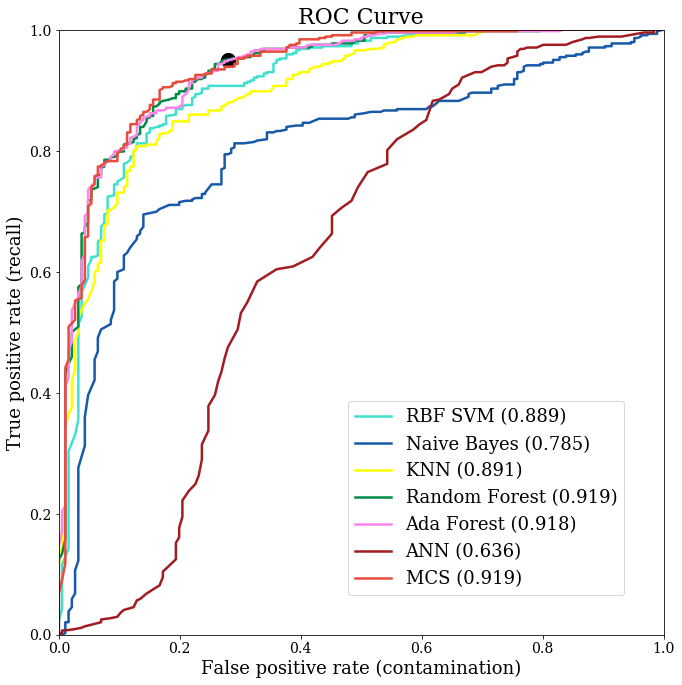

In [19]:
X_combined, Y , Sh, mean_S2z, std_S2z= prepare_data4ml_algorithms(feats, feat_S2z, feat_S2z_err)
RES_S2z=run_ml_plot(X_combined, Y, Sh)

In [20]:
RIimp1=np.array([[ 0.12735271,  0.21033708,  0.12022508,  0.33374648,  0.20833864],
[ 0.14280343,  0.20006701,  0.126407  ,  0.31047971,  0.22024284],
[ 0.13341268,  0.21210812,  0.1217683 ,  0.32939396,  0.20331694],
[ 0.14506217,  0.19947986,  0.12833169,  0.30781726,  0.21930902],
[ 0.13134749,  0.20782919,  0.12197772,  0.32910578,  0.20973981],
[ 0.14354333,  0.20102351,  0.12770847,  0.30727247,  0.22045222],
[ 0.12961569,  0.20931249,  0.12305188,  0.33036297,  0.20765696],
[ 0.14422296,  0.20086352,  0.12901834,  0.30655507,  0.21934011],
[ 0.13089256,  0.20964829,  0.12327722,  0.3279948 ,  0.20818712],
[ 0.14309021,  0.20140287,  0.12762349,  0.3079085 ,  0.21997493]])

print ('Rel Importance z  %.2f'%np.mean(RIimp1[:,0]))
print ('Rel Importance t0 %.2f'%np.mean(RIimp1[:,1]))
print ('Rel Importance x0 %.2f'%np.mean(RIimp1[:,2]))
print ('Rel Importance x1 %.2f'%np.mean(RIimp1[:,3]))
print ('Rel Importance c %.2f'%np.mean(RIimp1[:,4]))

Rel Importance z  0.14
Rel Importance t0 0.21
Rel Importance x0 0.12
Rel Importance x1 0.32
Rel Importance c 0.21


In [21]:
X, Y, FN_Ia, FP_Ia, TP_Ia, TN_Ia= results_analysis(RES_S2z)

FP 127 FN 40
TP 839 TN 250
########  purity:  87.0
########  efficiency:  95.0
FP 12 FN 522
TP 357 TN 365
########  purity chopping:  97.0
########  efficiency chopping:  41.0


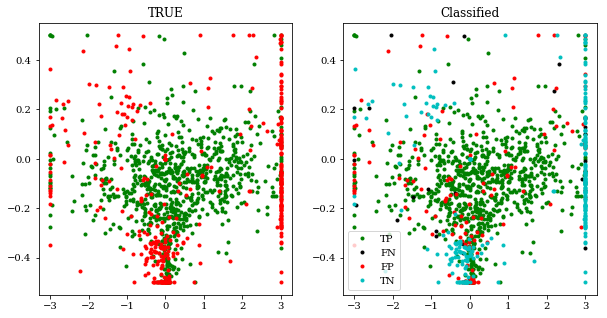

In [22]:
x1_rescaled=(X[:,3]*std_S2z[3])+mean_S2z[3]
c_rescaled=(X[:,4]*std_S2z[4])+mean_S2z[4]
fig=plt.figure(1,figsize=(10,5))
plt.subplot(121)
plt.title('TRUE')
plt.plot(x1_rescaled[Y==1], c_rescaled[Y==1], '.g')
plt.plot(x1_rescaled[Y!=1], c_rescaled[Y!=1], '.r')
plt.subplot(122)
plt.title('Classified')
plt.plot(x1_rescaled[TP_Ia], c_rescaled[TP_Ia], '.g', label='TP')
plt.plot(x1_rescaled[FN_Ia], c_rescaled[FN_Ia], '.k', label='FN')
plt.plot(x1_rescaled[FP_Ia], c_rescaled[FP_Ia], '.r', label='FP')
plt.plot(x1_rescaled[TN_Ia], c_rescaled[TN_Ia], '.c', label='TN')
plt.legend(loc='best')

scale_data_with_errors [  4.95541844e-01   1.78983016e+01   1.88463376e-05   5.56466498e-01
   6.53476664e-02] [  1.94270440e-01   1.72563215e+01   5.04067480e-05   1.60972467e+00
   2.00553712e-01]
(628, 5)
(628, 5)
KNN optimiser time taken: 0.633553981781
('FeatImp', array([ 0.23276919,  0.11769371,  0.09954551,  0.32913424,  0.22085735]))
('FeatImp', array([ 0.23177904,  0.11899414,  0.09836007,  0.30666247,  0.24420428]))
('FeatImp', array([ 0.23302385,  0.12276411,  0.09915344,  0.32201128,  0.22304732]))
('FeatImp', array([ 0.22985392,  0.12119402,  0.10004065,  0.30965974,  0.23925167]))
('FeatImp', array([ 0.22827413,  0.11679878,  0.10449872,  0.32964729,  0.22078109]))
('FeatImp', array([ 0.228758  ,  0.12025972,  0.09916492,  0.30828288,  0.24353448]))
('FeatImp', array([ 0.23258535,  0.1187833 ,  0.10165723,  0.32624718,  0.22072695]))
('FeatImp', array([ 0.22700835,  0.12051825,  0.09799262,  0.31063042,  0.24385036]))
('FeatImp', array([ 0.23503113,  0.12092676,  0.101948

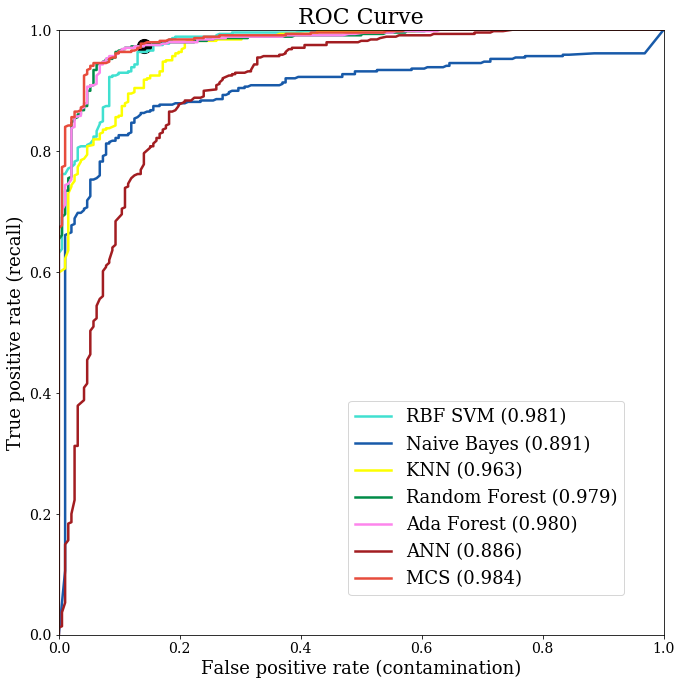

In [23]:
X_combined, Y , Sh, mean_zph, std_zph= prepare_data4ml_algorithms(feats, feat_zph, feat_zph_err)
RES_zph=run_ml_plot(X_combined, Y, Sh)

In [24]:
RIimp2=np.array([[ 0.27762725,  0.10482936,  0.09449045,  0.3144597 ,  0.20859324],
[ 0.24883403,  0.11017812,  0.08910699,  0.30220769,  0.24967317],
[ 0.2774932 ,  0.10329098,  0.09240843,  0.31562618,  0.21118122],
[ 0.25774747,  0.10738139,  0.08702666,  0.30042399,  0.24742048],
[ 0.26845196,  0.10590206,  0.09304455,  0.32087345,  0.21172797],
[ 0.25192469,  0.10796651,  0.08969066,  0.30272953,  0.24768861],
[ 0.27259014,  0.10568542,  0.09125482,  0.31968331,  0.21078632],
[ 0.25201111,  0.10678738,  0.08774064,  0.30391979,  0.24954107],
[ 0.26801239,  0.10556035,  0.09270374,  0.32339449,  0.21032903],
[ 0.25063765,  0.10598661,  0.08862144,  0.30419118,  0.25056313]])

print ('Rel Importance z  %.2f'%np.mean(RIimp2[:,0]))
print ('Rel Importance t0 %.2f'%np.mean(RIimp2[:,1]))
print ('Rel Importance x0 %.2f'%np.mean(RIimp2[:,2]))
print ('Rel Importance x1 %.2f'%np.mean(RIimp2[:,3]))
print ('Rel Importance c %.2f'%np.mean(RIimp2[:,4]))

Rel Importance z  0.26
Rel Importance t0 0.11
Rel Importance x0 0.09
Rel Importance x1 0.31
Rel Importance c 0.23


In [25]:
X, Y, FN_Ia, FP_Ia, TP_Ia, TN_Ia= results_analysis(RES_zph)

FP 52 FN 34
TP 845 TN 325
########  purity:  94.0
########  efficiency:  96.0
FP 0 FN 299
TP 580 TN 377
########  purity chopping:  100.0
########  efficiency chopping:  66.0


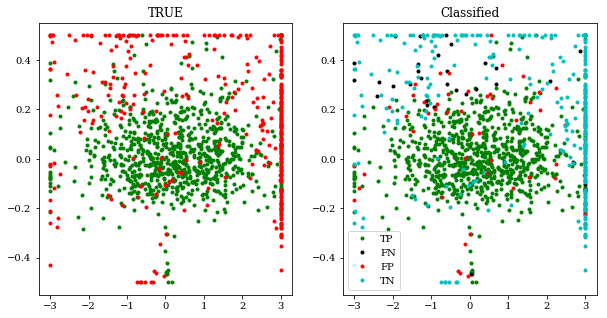

In [26]:
x1_rescaled=(X[:,3]*std_zph[3])+mean_zph[3]
c_rescaled=(X[:,4]*std_zph[4])+mean_zph[4]

fig=plt.figure(1,figsize=(10,5))
plt.subplot(121)
plt.title('TRUE')
plt.plot(x1_rescaled[Y==1], c_rescaled[Y==1], '.g')
plt.plot(x1_rescaled[Y!=1], c_rescaled[Y!=1], '.r')
plt.subplot(122)
plt.title('Classified')
plt.plot(x1_rescaled[TP_Ia], c_rescaled[TP_Ia], '.g', label='TP')
plt.plot(x1_rescaled[FN_Ia], c_rescaled[FN_Ia], '.k', label='FN')
plt.plot(x1_rescaled[FP_Ia], c_rescaled[FP_Ia], '.r', label='FP')
plt.plot(x1_rescaled[TN_Ia], c_rescaled[TN_Ia], '.c', label='TN')

plt.legend(loc='best')

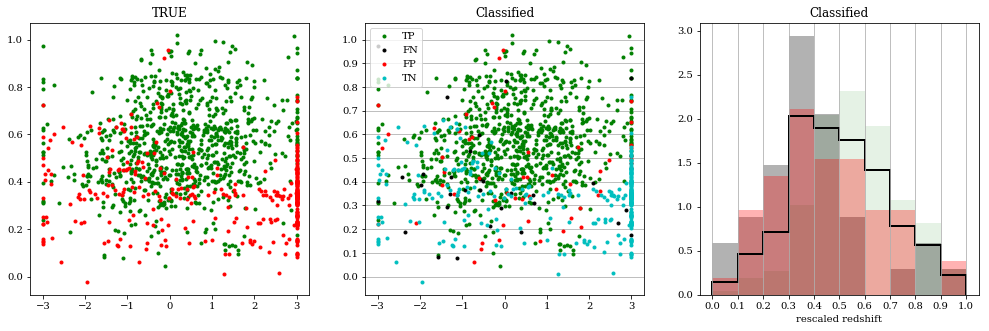

In [27]:
z_rescaled=(X[:,0]*std_zph[0])+mean_zph[0]
fig=plt.figure(1,figsize=(17,5))
plt.subplot(131)
plt.title('TRUE')
plt.plot(x1_rescaled[Y==1], z_rescaled[Y==1], '.g')
plt.plot(x1_rescaled[Y!=1], z_rescaled[Y!=1], '.r')
plt.subplot(132)
plt.title('Classified')
plt.plot(x1_rescaled[TP_Ia], z_rescaled[TP_Ia], '.g', label='TP')
plt.plot(x1_rescaled[FN_Ia], z_rescaled[FN_Ia], '.k', label='FN')
plt.plot(x1_rescaled[FP_Ia], z_rescaled[FP_Ia], '.r', label='FP')
plt.plot(x1_rescaled[TN_Ia], z_rescaled[TN_Ia], '.c', label='TN')
plt.legend(loc='best')
bins=np.arange(0,1.1,0.1)
plt.yticks(bins)
plt.grid(axis='y')
plt.subplot(133)
plt.title('Classified')
plt.hist(z_rescaled[TP_Ia], facecolor='g', alpha=0.1, bins=bins, normed=True)
plt.hist(z_rescaled[FN_Ia], facecolor='k', alpha=0.3, bins=bins, normed=True)
plt.hist(z_rescaled[FP_Ia], facecolor='r', alpha=0.3, bins=bins, normed=True)
plt.hist(z_rescaled, color='k', lw=2, bins=bins, histtype='step',normed=True)

plt.xlabel('rescaled redshift')
plt.xticks(bins)
plt.grid(axis='x')



(array([   1.,    5.,    8.,   11.,    8.,   20.,   41.,   55.,  100.,
          79.,   98.,  100.,  113.,   49.,   50.,   42.,   58.,   13.,
          15.,   11.,    2.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
         1.35,  1.4 ,  1.45]),
 <a list of 29 Patch objects>)

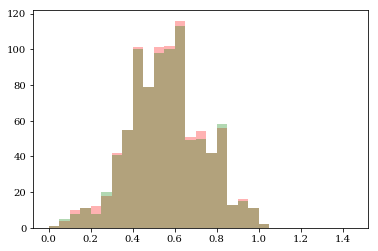

In [28]:
bins=np.arange(0,1.5,0.05)
plt.hist(z_rescaled[(TP_Ia)|(FP_Ia)], facecolor='r', alpha=0.3, bins=bins, label='Classified Ia SNe')
plt.hist(z_rescaled[Y==1], facecolor='g', alpha=0.3, bins=bins, label='TRUE Ia SNe')

scale_data_with_errors [  0.48687836  17.20413384  -4.97476711   0.52160928   0.08016663] [  0.19867602  19.0530017    0.36873045   1.57970335   0.21885594]
(627, 5)
(628, 5)
KNN optimiser time taken: 0.51571393013
('FeatImp', array([ 0.20896457,  0.09956549,  0.09452427,  0.32686712,  0.27007855]))
('FeatImp', array([ 0.20671124,  0.09448748,  0.09803078,  0.29402756,  0.30674294]))
('FeatImp', array([ 0.20217011,  0.09676464,  0.09417614,  0.33042178,  0.27646734]))
('FeatImp', array([ 0.19706355,  0.09259289,  0.09421171,  0.29258797,  0.32354389]))
('FeatImp', array([ 0.20315146,  0.09784982,  0.09547213,  0.33025081,  0.27327578]))
('FeatImp', array([ 0.2017789 ,  0.09090389,  0.0962281 ,  0.29489079,  0.31619833]))
('FeatImp', array([ 0.20498573,  0.09708718,  0.09452497,  0.32999562,  0.27340651]))
('FeatImp', array([ 0.20000621,  0.09223713,  0.09444771,  0.29591522,  0.31739372]))
('FeatImp', array([ 0.2047993 ,  0.09718682,  0.09509323,  0.32841426,  0.27450639]))
('FeatImp',

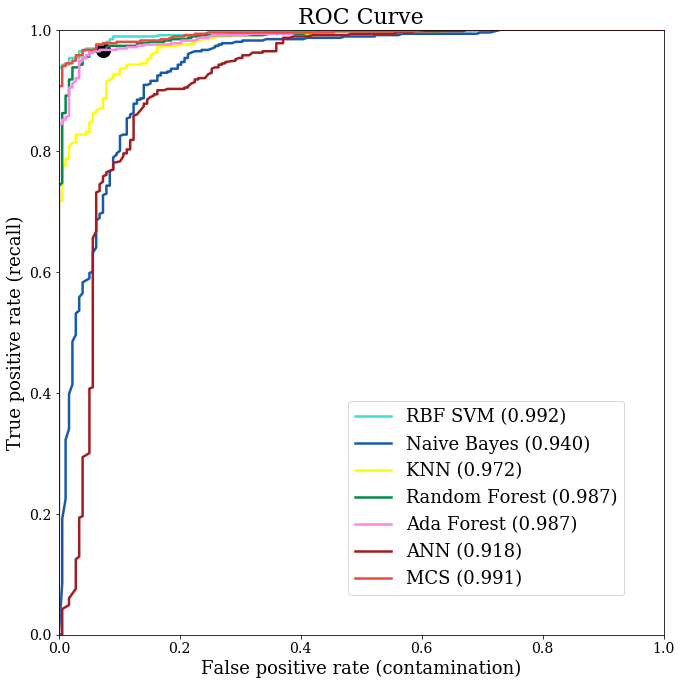

In [16]:
X_combined, Y_keys , Sh, mean_zsp, std_zsp= prepare_data4ml_algorithms(feats_log10, feat_zsp, feat_zsp_err)
RES_zsp=run_ml_plot(X_combined, Y_keys, Sh)

In [17]:
feats_log10.shape

(1255, 37)

In [18]:
RIimp3=np.array([
#[ 0.19697312,  0.08686784,  0.09735561,  0.35000097,  0.26880245],
#[ 0.19497021,  0.08912787,  0.09602479,  0.31493741,  0.30493972],
#[ 0.18835801,  0.08882174,  0.09746593,  0.35555184,  0.26980249],
#[ 0.18887729,  0.0919426 ,  0.09544901,  0.31139334,  0.31233776],
#[ 0.19001229,  0.08923297,  0.09572648,  0.35525778,  0.26977047],
#[ 0.19209096,  0.09282704,  0.09156663,  0.31768024,  0.30583512],
#[ 0.19082879,  0.09016467,  0.0980685 ,  0.35122947,  0.26970857],
#[ 0.19345403,  0.09015743,  0.09498056,  0.31310239,  0.30830558],
#[ 0.18859698,  0.08896762,  0.09656924,  0.35317439,  0.27269177],
#[ 0.19162351,  0.0932521 ,  0.09344065,  0.31415805,  0.3075257 ]])
#
[ 0.20774858,  0.10785064,  0.10129629,  0.30860408,  0.2745004 ],
[ 0.19599901,  0.10342482,  0.10351763,  0.27133041,  0.32572813],
[ 0.20387424,  0.10310547,  0.10438282,  0.31066237,  0.2779751 ],
[ 0.20138054,  0.10251988,  0.10325656,  0.26811833,  0.32472469],
[ 0.20028534,  0.10504692,  0.10463116,  0.30864951,  0.28138706],
[ 0.19434606,  0.10199874,  0.10229262,  0.27288326,  0.32847931],
[ 0.20680982,  0.10442043,  0.10543104,  0.30917839,  0.27416032],
[ 0.19400879,  0.10361318,  0.1040295 ,  0.2714006 ,  0.32694793],
[ 0.20579257,  0.10387512,  0.1049763 ,  0.30802773,  0.27732828],
[ 0.20004979,  0.10179518,  0.10456872,  0.27114064,  0.32244566]])
                  
print ('Rel Importance z  %.2f'%np.mean(RIimp3[:,0]))
print ('Rel Importance t0 %.2f'%np.mean(RIimp3[:,1]))
print ('Rel Importance x0 %.2f'%np.mean(RIimp3[:,2]))
print ('Rel Importance x1 %.2f'%np.mean(RIimp3[:,3]))
print ('Rel Importance c %.2f'%np.mean(RIimp3[:,4]))

Rel Importance z  0.20
Rel Importance t0 0.10
Rel Importance x0 0.10
Rel Importance x1 0.29
Rel Importance c 0.30


In [31]:
X, Y, FN_Ia, FP_Ia, TP_Ia, TN_Ia, FN_Ia_chop, FP_Ia_chop, TP_Ia_chop, TN_Ia_chop= results_analysis(RES_zsp,\
                                                                                                   chopped_also=True)

FP 50 FN 25
TP 853 TN 327
########  purity:  94.0
########  efficiency:  97.0
FP 1 FN 240
TP 638 TN 376
########  purity chopping:  100.0
########  efficiency chopping:  73.0


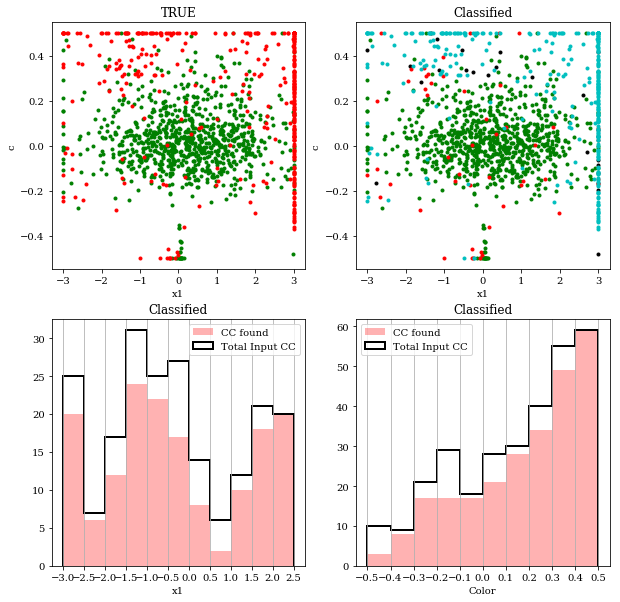

In [26]:
x1_rescaled=(X[:,3]*std_zsp[3])+mean_zsp[3]
c_rescaled= (X[:,4]*std_zsp[4])+mean_zsp[4]
z_rescaled= (X[:,0]*std_zsp[0])+mean_zsp[0]

fig=plt.figure(1,figsize=(10,10))
plt.subplot(221)
plt.title('TRUE')
plt.plot(x1_rescaled[Y==1], c_rescaled[Y==1], '.g')
plt.plot(x1_rescaled[Y!=1], c_rescaled[Y!=1], '.r')
plt.xlabel('x1')
plt.ylabel('c')
plt.subplot(222)
plt.title('Classified')
plt.plot(x1_rescaled[TP_Ia], c_rescaled[TP_Ia], '.g', label='TP')
plt.plot(x1_rescaled[FN_Ia], c_rescaled[FN_Ia], '.k', label='FN')
plt.plot(x1_rescaled[FP_Ia], c_rescaled[FP_Ia], '.r', label='FP')
plt.plot(x1_rescaled[TN_Ia], c_rescaled[TN_Ia], '.c', label='TN')
#plt.hlines([-0.3,0.3], -3, 3, linestyle='--')
#plt.vlines([-3,3], -0.3, 0.3, linestyle='--')
plt.xlabel('x1')
plt.ylabel('c')
plt.subplot(223)
plt.title('Classified')
bins=np.arange(-3,3., 0.5)
plt.hist(x1_rescaled[TN_Ia], facecolor='r', alpha=0.3, bins=bins, label='CC found')
plt.hist(x1_rescaled[FP_Ia|TN_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('x1')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(224)
bins=np.arange(-0.5,0.6, 0.1)
plt.title('Classified')
plt.hist(c_rescaled[TN_Ia], facecolor='r', alpha=0.3, bins=bins, label='CC found')
plt.hist(c_rescaled[FP_Ia|TN_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('Color')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()

plt.legend(loc='best')

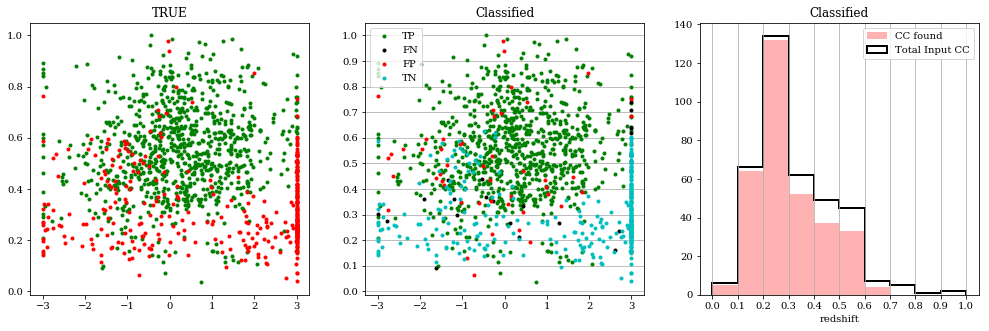

In [27]:
fig=plt.figure(1,figsize=(17,5))
plt.subplot(131)
plt.title('TRUE')
plt.plot(x1_rescaled[Y==1], z_rescaled[Y==1], '.g')
plt.plot(x1_rescaled[Y!=1], z_rescaled[Y!=1], '.r')
plt.subplot(132)
plt.title('Classified')
plt.plot(x1_rescaled[TP_Ia], z_rescaled[TP_Ia], '.g', label='TP')
plt.plot(x1_rescaled[FN_Ia], z_rescaled[FN_Ia], '.k', label='FN')
plt.plot(x1_rescaled[FP_Ia], z_rescaled[FP_Ia], '.r', label='FP')
plt.plot(x1_rescaled[TN_Ia], z_rescaled[TN_Ia], '.c', label='TN')
plt.legend(loc='best')
bins=np.arange(0,1.1,0.1)
plt.yticks(bins)
plt.grid(axis='y')
plt.subplot(133)
plt.title('Classified')
#plt.hist(z_rescaled[TP_Ia], facecolor='g', alpha=0.1, bins=bins)
#plt.hist(z_rescaled[FN_Ia], facecolor='k', alpha=0.3, bins=bins)
plt.hist(z_rescaled[TN_Ia], facecolor='r', alpha=0.3, bins=bins, label='CC found')
plt.hist(z_rescaled[FP_Ia|TN_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('redshift')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()


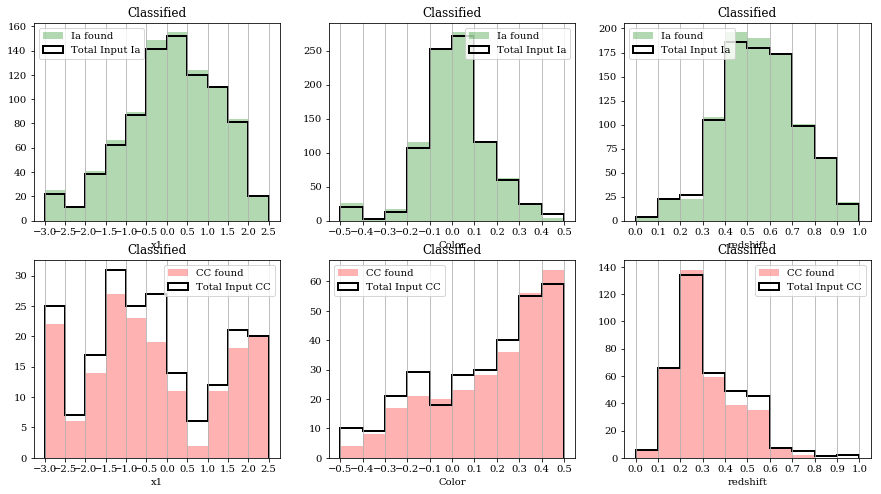

In [46]:
fig=plt.figure(1,figsize=(15,8))
plt.subplot(234)
plt.title('Classified')
bins=np.arange(-3,3., 0.5)
x_CC_hist_found_notchoped=plt.hist(x1_rescaled[TN_Ia|FN_Ia], facecolor='r', alpha=0.3, bins=bins,  label='CC found')
x_CC_hist_input_notchoped=plt.hist(x1_rescaled[FP_Ia|TN_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('x1')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(235)
bins=np.arange(-0.5,0.6, 0.1)
plt.title('Classified')
c_CC_hist_found_notchoped=plt.hist(c_rescaled[TN_Ia|FN_Ia], facecolor='r', alpha=0.3, bins=bins,  label='CC found')
c_CC_hist_input_notchoped=plt.hist(c_rescaled[FP_Ia|TN_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('Color')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(236)
bins=np.arange(0.,1.05, 0.1)
plt.title('Classified')
z_CC_hist_found_notchoped=plt.hist(z_rescaled[TN_Ia|FN_Ia], facecolor='r', alpha=0.3, bins=bins,  label='CC found')
z_CC_hist_input_notchoped=plt.hist(z_rescaled[FP_Ia|TN_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('redshift')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()

plt.subplot(231)
plt.title('Classified')
bins=np.arange(-3,3., 0.5)
x_Ia_hist_found_notchoped=plt.hist(x1_rescaled[TP_Ia|FP_Ia], facecolor='g', alpha=0.3, bins=bins,  label='Ia found')
x_Ia_hist_input_notchoped=plt.hist(x1_rescaled[FN_Ia|TP_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input Ia')
plt.xlabel('x1')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(232)
bins=np.arange(-0.5,0.6, 0.1)
plt.title('Classified')
c_Ia_hist_found_notchoped=plt.hist(c_rescaled[TP_Ia|FP_Ia], facecolor='g', alpha=0.3, bins=bins,  label='Ia found')
c_Ia_hist_input_notchoped=plt.hist(c_rescaled[FN_Ia|TP_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input Ia')
plt.xlabel('Color')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(233)
bins=np.arange(0.,1.05, 0.1)
plt.title('Classified')
z_Ia_hist_found_notchoped=plt.hist(z_rescaled[TP_Ia|FP_Ia], facecolor='g', alpha=0.3, bins=bins,  label='Ia found')
z_Ia_hist_input_notchoped=plt.hist(z_rescaled[FN_Ia|TP_Ia], color='k',lw=2, bins=bins, histtype='step', label='Total Input Ia')
plt.xlabel('redshift')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()




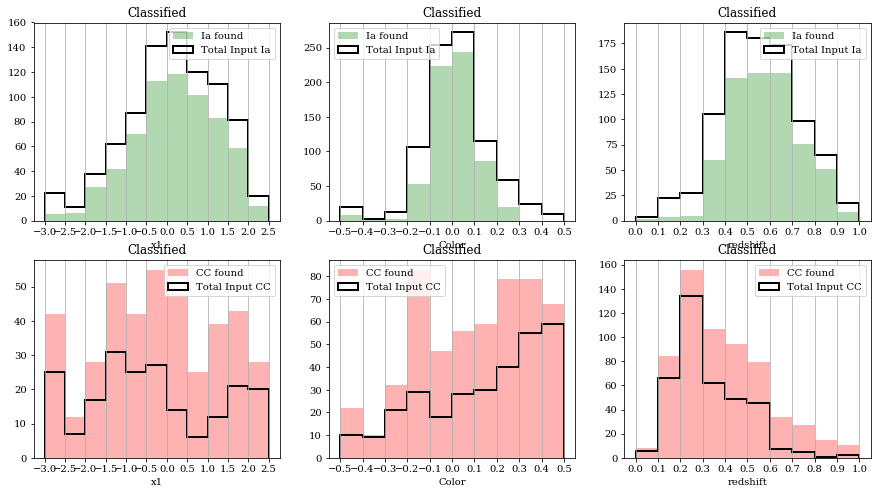

In [35]:
fig=plt.figure(1,figsize=(15,8))
plt.subplot(234)
plt.title('Classified')
bins=np.arange(-3,3., 0.5)
x_CC_hist_found=plt.hist(x1_rescaled[TN_Ia_chop|FN_Ia_chop], facecolor='r', alpha=0.3, bins=bins,  label='CC found')
x_CC_hist_input=plt.hist(x1_rescaled[FP_Ia_chop|TN_Ia_chop], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('x1')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(235)
bins=np.arange(-0.5,0.6, 0.1)
plt.title('Classified')
c_CC_hist_found=plt.hist(c_rescaled[TN_Ia_chop|FN_Ia_chop], facecolor='r', alpha=0.3, bins=bins,  label='CC found')
c_CC_hist_input=plt.hist(c_rescaled[FP_Ia_chop|TN_Ia_chop], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('Color')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(236)
bins=np.arange(0.,1.05, 0.1)
plt.title('Classified')
z_CC_hist_found=plt.hist(z_rescaled[TN_Ia_chop|FN_Ia_chop], facecolor='r', alpha=0.3, bins=bins,  label='CC found')
z_CC_hist_input=plt.hist(z_rescaled[FP_Ia_chop|TN_Ia_chop], color='k',lw=2, bins=bins, histtype='step', label='Total Input CC')
plt.xlabel('redshift')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()

plt.subplot(231)
plt.title('Classified')
bins=np.arange(-3,3., 0.5)
x_Ia_hist_found=plt.hist(x1_rescaled[TP_Ia_chop|FP_Ia_chop], facecolor='g', alpha=0.3, bins=bins,  label='Ia found')
x_Ia_hist_input=plt.hist(x1_rescaled[FN_Ia_chop|TP_Ia_chop], color='k',lw=2, bins=bins, histtype='step', label='Total Input Ia')
plt.xlabel('x1')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(232)
bins=np.arange(-0.5,0.6, 0.1)
plt.title('Classified')
c_Ia_hist_found=plt.hist(c_rescaled[TP_Ia_chop|FP_Ia_chop], facecolor='g', alpha=0.3, bins=bins,  label='Ia found')
c_Ia_hist_input=plt.hist(c_rescaled[FN_Ia_chop|TP_Ia_chop], color='k',lw=2, bins=bins, histtype='step', label='Total Input Ia')
plt.xlabel('Color')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()
plt.subplot(233)
bins=np.arange(0.,1.05, 0.1)
plt.title('Classified')
z_Ia_hist_found=plt.hist(z_rescaled[TP_Ia_chop|FP_Ia_chop], facecolor='g', alpha=0.3, bins=bins,  label='Ia found')
z_Ia_hist_input=plt.hist(z_rescaled[FN_Ia_chop|TP_Ia_chop], color='k',lw=2, bins=bins, histtype='step', label='Total Input Ia')
plt.xlabel('redshift')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend()




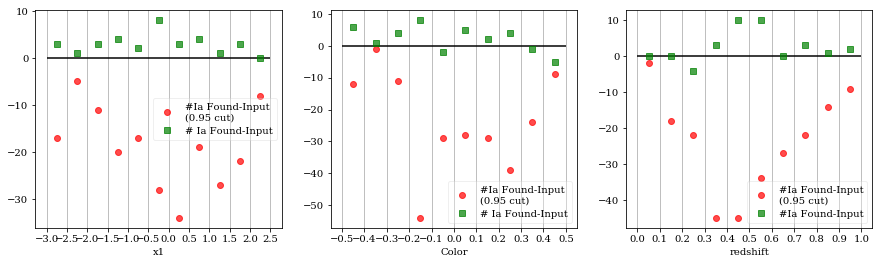

In [63]:
fig=plt.figure(1,figsize=(15,4))

plt.subplot(131)
bins=np.arange(-3,3., 0.5)
plt.hlines(0, bins[0], bins[-1])
plt.plot(bins[:-1]+0.5*(bins[1]-bins[0]), x_Ia_hist_found[0]-x_Ia_hist_input[0], 'or', alpha=0.7, label='#Ia Found-Input\n(0.95 cut)')
plt.plot(bins[:-1]+0.5*(bins[1]-bins[0]), x_Ia_hist_found_notchoped[0]-x_Ia_hist_input_notchoped[0], 'sg', alpha=0.7, label='# Ia Found-Input')
plt.xlabel('x1')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend(loc='best', framealpha=0.3)

plt.subplot(132)
bins=np.arange(-0.5,0.6, 0.1)
plt.hlines(0, bins[0], bins[-1])
plt.plot(bins[:-1]+0.5*(bins[1]-bins[0]), c_Ia_hist_found[0]-c_Ia_hist_input[0], 'or', alpha=0.7, label='#Ia Found-Input\n(0.95 cut)')
plt.plot(bins[:-1]+0.5*(bins[1]-bins[0]), c_Ia_hist_found_notchoped[0]-c_Ia_hist_input_notchoped[0], 'sg', alpha=0.7, label='# Ia Found-Input')
plt.xlabel('Color')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend(loc='best', framealpha=0.3)

plt.subplot(133)
bins=np.arange(0.,1.05, 0.1)
plt.hlines(0, bins[0], bins[-1])
plt.plot(bins[:-1]+0.5*(bins[1]-bins[0]), z_Ia_hist_found[0]-z_Ia_hist_input[0], 'or', alpha=0.7, label='#Ia Found-Input\n(0.95 cut)')
plt.plot(bins[:-1]+0.5*(bins[1]-bins[0]), z_Ia_hist_found_notchoped[0]-z_Ia_hist_input_notchoped[0], 'sg', alpha=0.7, label='#Ia Found-Input')
plt.xlabel('redshift')
plt.xticks(bins)
plt.grid(axis='x')
plt.legend(loc='best', framealpha=0.3)


In [57]:
plt.legend?

In [23]:
from astropy.cosmology import Planck15 as cosmo 

feats_log10_mu=np.copy(feats_log10)

logx0=feats_log10[:,30]
mB=30.-19.46-2.5*np.array(logx0,dtype=float)\
    +0.11*np.array(feats_log10[:,32],dtype=float)-2.6*np.array(feats_log10[:,34],dtype=float)
feats_log10_mu[:,30]=mB-cosmo.distmod(np.array(feats_log10[:,26],dtype=float)).value


scale_data_with_errors [  0.48687836  17.20413384 -19.18503741   0.52160928   0.08016663] [  0.19867602  19.0530017    0.78948712   1.57970335   0.21885594]
(627, 5)
(628, 5)
KNN optimiser time taken: 0.538682937622
('FeatImp', array([ 0.12842338,  0.07311524,  0.37207294,  0.23358585,  0.19280259]))
('FeatImp', array([ 0.11429982,  0.07817356,  0.37695134,  0.20679346,  0.22378182]))
('FeatImp', array([ 0.12950937,  0.07283248,  0.38175171,  0.23374617,  0.18216026]))
('FeatImp', array([ 0.11343551,  0.07677117,  0.3636438 ,  0.21408637,  0.23206314]))
('FeatImp', array([ 0.13140249,  0.07322761,  0.38187095,  0.22802414,  0.18547481]))
('FeatImp', array([ 0.11263818,  0.0743652 ,  0.36494011,  0.21771607,  0.23034044]))
('FeatImp', array([ 0.13257421,  0.07258287,  0.37623723,  0.22931987,  0.18928582]))
('FeatImp', array([ 0.11449021,  0.07582918,  0.37268674,  0.21244366,  0.2245502 ]))
('FeatImp', array([ 0.1315938 ,  0.07358783,  0.38274382,  0.2279026 ,  0.18417194]))
('FeatImp'

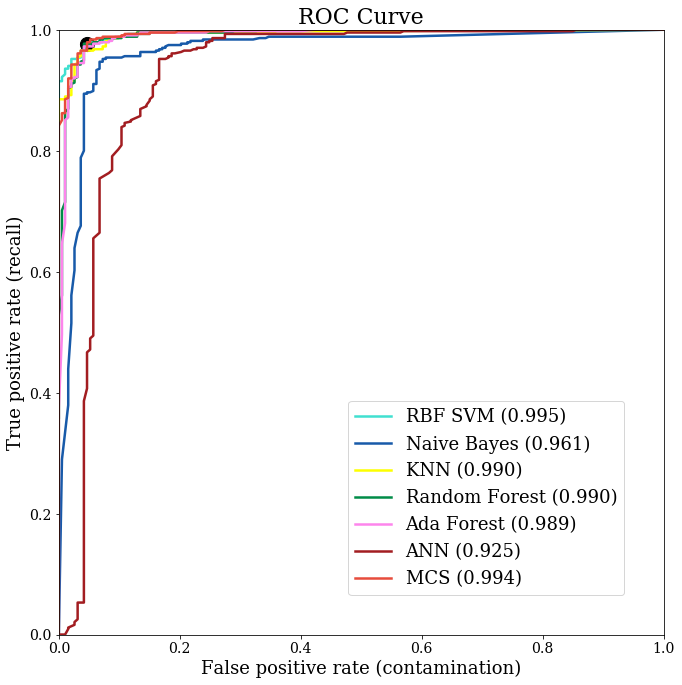

In [24]:
X_combined, Y_keys , Sh, mean_zsp, std_zsp= prepare_data4ml_algorithms(feats_log10_mu, feat_zsp, feat_zsp_err)
RES_zsp_Hres=run_ml_plot(X_combined, Y_keys, Sh)

In [38]:
Other_results= results_analysis(RES_zsp_Hres) ##  mB

RIimpmB=np.array([[ 0.12762091,  0.07397745,  0.36316178,  0.28229314,  0.15294672],
[ 0.19362042,  0.10240615,  0.10749378,  0.31439086,  0.2820888 ],
[ 0.19799748,  0.09804381,  0.10737443,  0.28332035,  0.31326392],
[ 0.1954468 ,  0.10578926,  0.10540462,  0.31261698,  0.28074234],
[ 0.19935864,  0.09987887,  0.10800973,  0.28060198,  0.31215077],
[ 0.20611869,  0.10584629,  0.10637924,  0.3054109 ,  0.27624488],
[ 0.19682735,  0.10006975,  0.10756451,  0.27992272,  0.31561567],
[ 0.20032751,  0.10595874,  0.10420545,  0.3111755 ,  0.27833281],
[ 0.19760408,  0.09828681,  0.10942226,  0.28273435,  0.31195249],
[ 0.19980599,  0.10602198,  0.10409948,  0.3114238 ,  0.27864876],
[ 0.20017607,  0.09794689,  0.10835849,  0.28348094,  0.31003761]])


FP 40 FN 26
TP 852 TN 337
########  purity:  96.0
########  efficiency:  97.0
FP 3 FN 234
TP 644 TN 374
########  purity chopping:  100.0
########  efficiency chopping:  73.0


In [39]:
Other_results= results_analysis(RES_zsp_Hres) ### Hres

FP 40 FN 26
TP 852 TN 337
########  purity:  96.0
########  efficiency:  97.0
FP 3 FN 234
TP 644 TN 374
########  purity chopping:  100.0
########  efficiency chopping:  73.0


In [40]:
RIimpResiduals=np.array([[ 0.12762091,  0.07397745,  0.36316178,  0.28229314,  0.15294672],
[ 0.1105078 ,  0.08238818,  0.34715312,  0.26559303,  0.19435787],
[ 0.1198376 ,  0.07840462,  0.37290276,  0.27205132,  0.15680369],
[ 0.10633483,  0.08156993,  0.35458827,  0.26388397,  0.193623  ],
[ 0.12010629,  0.07959998,  0.3620823 ,  0.28186069,  0.15635073],
[ 0.10615858,  0.0838843 ,  0.34815025,  0.26264964,  0.19915724],
[ 0.11715945,  0.0789491 ,  0.3778262 ,  0.27439979,  0.15166546],
[ 0.11063267,  0.08371039,  0.34236006,  0.26286964,  0.20042723],
[ 0.12219797,  0.07974537,  0.37034115,  0.27498213,  0.15273338],
[ 0.10763857,  0.08152091,  0.35604063,  0.25952168,  0.19527821]])


print ('Rel Importance z  %.2f'%np.mean(RIimpResiduals[:,0]))
print ('Rel Importance t0 %.2f'%np.mean(RIimpResiduals[:,1]))
print ('Rel Importance x0 %.2f'%np.mean(RIimpResiduals[:,2]))
print ('Rel Importance x1 %.2f'%np.mean(RIimpResiduals[:,3]))
print ('Rel Importance c %.2f'%np.mean(RIimpResiduals[:,4]))

Rel Importance z  0.11
Rel Importance t0 0.08
Rel Importance x0 0.36
Rel Importance x1 0.27
Rel Importance c 0.18


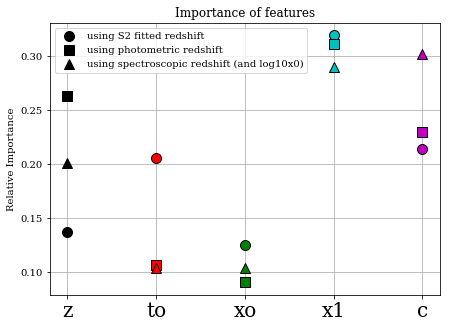

In [41]:
fig=plt.figure(1, figsize=(7,5))
plt.plot(0, np.mean(RIimp1[:,0]), 'ok',ms=10, mec='k', label='using S2 fitted redshift')
plt.plot(0, np.mean(RIimp2[:,0]), 'sk',ms=10, mec='k', label='using photometric redshift')
plt.plot(0, np.mean(RIimp3[:,0]), '^k',ms=10, mec='k', label='using spectroscopic redshift (and log10x0)')
#plt.plot(0, np.mean(RIimpResiduals[:,0]), '^k', label='Using Hubble Residuals instead of log(x0)')

plt.plot(1, np.mean(RIimp1[:,1]), 'or', ms=10, mec='k')
plt.plot(1, np.mean(RIimp2[:,1]), 'sr', ms=10, mec='k')
plt.plot(1, np.mean(RIimp3[:,1]), '^r', ms=10, mec='k')
#plt.plot(1, np.mean(RIimpResiduals[:,1]), '^r')

plt.plot(2, np.mean(RIimp1[:,2]), 'og', ms=10, mec='k')
plt.plot(2, np.mean(RIimp2[:,2]), 'sg', ms=10, mec='k')
plt.plot(2, np.mean(RIimp3[:,2]), '^g', ms=10, mec='k')
#plt.plot(2, np.mean(RIimpResiduals[:,2]), '^g')

plt.plot(3, np.mean(RIimp1[:,3]), 'oc', ms=10, mec='k')
plt.plot(3, np.mean(RIimp2[:,3]), 'sc', ms=10, mec='k')
plt.plot(3, np.mean(RIimp3[:,3]), '^c', ms=10, mec='k')
#plt.plot(3, np.mean(RIimpResiduals[:,3]), '^c')

plt.plot(4, np.mean(RIimp1[:,4]), 'om', ms=10, mec='k')
plt.plot(4, np.mean(RIimp2[:,4]), 'sm', ms=10, mec='k')
plt.plot(4, np.mean(RIimp3[:,4]), '^m', ms=10, mec='k')
#plt.plot(4, np.mean(RIimpResiduals[:,4]), '^m')

plt.xticks([0,1,2,3,4], ['z','to', 'xo', 'x1','c'], fontsize=20)
plt.legend(loc='best')
plt.title('Importance of features')
plt.ylabel('Relative Importance')
plt.grid()

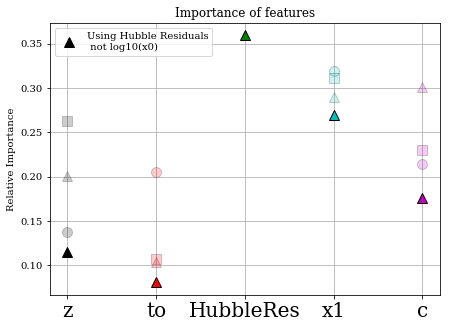

In [42]:
fig=plt.figure(1, figsize=(7,5))

plt.plot(0, np.mean(RIimp1[:,0]), 'ok',ms=10, mec='k', alpha=0.2)
plt.plot(0, np.mean(RIimp2[:,0]), 'sk',ms=10, mec='k', alpha=0.2)
plt.plot(0, np.mean(RIimp3[:,0]), '^k',ms=10, mec='k', alpha=0.2)

plt.plot(1, np.mean(RIimp1[:,1]), 'or', ms=10, mec='k', alpha=0.2)
plt.plot(1, np.mean(RIimp2[:,1]), 'sr', ms=10, mec='k', alpha=0.2)
plt.plot(1, np.mean(RIimp3[:,1]), '^r', ms=10, mec='k', alpha=0.2)

plt.plot(3, np.mean(RIimp1[:,3]), 'oc', ms=10, mec='k', alpha=0.2)
plt.plot(3, np.mean(RIimp2[:,3]), 'sc', ms=10, mec='k', alpha=0.2)
plt.plot(3, np.mean(RIimp3[:,3]), '^c', ms=10, mec='k', alpha=0.2)

plt.plot(4, np.mean(RIimp1[:,4]), 'om', ms=10, mec='k', alpha=0.2)
plt.plot(4, np.mean(RIimp2[:,4]), 'sm', ms=10, mec='k', alpha=0.2)
plt.plot(4, np.mean(RIimp3[:,4]), '^m', ms=10, mec='k', alpha=0.2)


plt.plot(0, np.mean(RIimpResiduals[:,0]), '^k', ms=10, mec='k', label='Using Hubble Residuals\n not log10(x0)')
plt.plot(1, np.mean(RIimpResiduals[:,1]), '^r', ms=10, mec='k')
plt.plot(2, np.mean(RIimpResiduals[:,2]), '^g', ms=10, mec='k')
plt.plot(3, np.mean(RIimpResiduals[:,3]), '^c', ms=10, mec='k')
plt.plot(4, np.mean(RIimpResiduals[:,4]), '^m', ms=10, mec='k')
plt.xticks([0,1,2,3,4], ['z','to', 'HubbleRes', 'x1','c'], fontsize=20)
plt.legend(loc='upper left')
plt.ylabel('Relative Importance')
plt.title('Importance of features')
plt.grid()

In [43]:
list_indexes=[]
file_redshift=np.array([np.round(float(z),3) for z in feats_log10[:,26]])
file_x1=np.array([np.round(float(z),3) for z in feats_log10[:,32]])
file_colors=np.array([np.round(float(z),3) for z in feats_log10[:,34]])


In [44]:
feats_log10.shape

(1255, 37)

In [45]:
x0_rescaled=(X[:,2]*std_zsp[2])+mean_zsp[2]
x1_rescaled=(X[:,3]*std_zsp[3])+mean_zsp[3]
c_rescaled= (X[:,4]*std_zsp[4])+mean_zsp[4]
z_rescaled= (X[:,0]*std_zsp[0])+mean_zsp[0]

des_file_associated=[]
mb_associated=[]

for i in range(len(z_rescaled)):
    z=np.round(z_rescaled[i],3); x1=np.round(x1_rescaled[i],3); c=np.round(c_rescaled[i],3)
    ind = np.where(file_redshift==z)[0]
    ind2 = np.where(file_x1==x1)[0]
    ind3 = np.where(file_colors==c)[0]
    index_file = np.intersect1d(np.intersect1d(ind, ind2), ind3)
    if len(index_file)!=1: 
        index_file_2= np.intersect1d(ind, ind3)
        index_file_3= np.intersect1d(ind, ind2)
        index_file_4= np.intersect1d(ind3, ind2)
        if np.any([len(index_file_2)==1, len(index_file_3)==1, len(index_file_4)==1]):
            index_file= np.array([\
                        index_file_2, index_file_3, index_file_4])[\
                             np.where([len(index_file_2)==1, len(index_file_3)==1, len(index_file_4)==1])[0]]
            des_file_associated.append((feats_log10[:,0])[index_file[0][0]])
            mb_associated.append(float((feats_log10[:,36])[index_file[0][0]]))
        else: 
            des_file_associated.append('')
            mb_associated.append(np.nan)                
    else:
        des_file_associated.append((feats_log10[:,0])[index_file[0]])
        mb_associated.append((feats_log10[:,36])[index_file[0]])



In [46]:
mb_associated=np.array(mb_associated, dtype=float)

In [47]:
alpha=0.11
beta=2.6
mu_from_mb=mb_associated+19.05+alpha*x1_rescaled-beta*c_rescaled
mu_obs=30.-2.5*(x0_rescaled)+alpha*x1_rescaled-beta*c_rescaled
res_obs=mu_obs - cosmo.distmod(z_rescaled).value

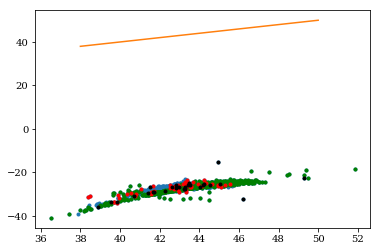

In [48]:
plt.plot(mu_from_mb,mu_obs, '.')
plt.plot(mu_from_mb[TP_Ia],mu_obs[TP_Ia], '.g')
plt.plot(mu_from_mb[FP_Ia],mu_obs[FP_Ia], '.r')
plt.plot(mu_from_mb[FN_Ia],mu_obs[FN_Ia], '.k')
plt.plot([38,50],[38,50])

(10, 14)

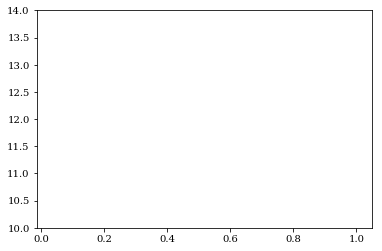

In [49]:
plt.plot(z_rescaled[TP_Ia], -2.5*(x0_rescaled[TP_Ia]), '.g', label='TP', alpha=0.1)
plt.plot(z_rescaled[FN_Ia], -2.5*(x0_rescaled[FN_Ia]), '.k', label='FN')
plt.plot(z_rescaled[FP_Ia], -2.5*(x0_rescaled[FP_Ia]), '.r', label='FP')
#plt.plot(np.log10(x0_rescaled[TN_Ia]),mu_obs[TN_Ia], '.c', label='TN')
plt.ylim(10,14)

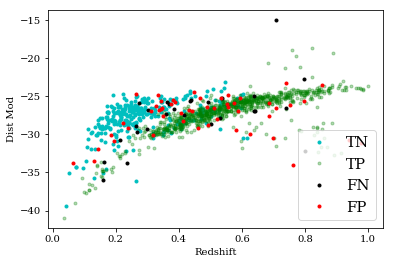

In [50]:
plt.plot(z_rescaled[TN_Ia], mu_obs[TN_Ia], '.c', label='TN')
plt.plot(z_rescaled[TP_Ia], mu_obs[TP_Ia], '.g', label='TP', alpha=0.3)
plt.plot(z_rescaled[FN_Ia], mu_obs[FN_Ia], '.k', label='FN')
plt.plot(z_rescaled[FP_Ia], mu_obs[FP_Ia], '.r', label='FP')
#plt.plot(z_rescaled, cosmo.distmod(z_rescaled), '.k', alpha=0.1)
plt.xlabel('Redshift')
plt.ylabel('Dist Mod')
plt.legend(loc='best', fontsize=15)

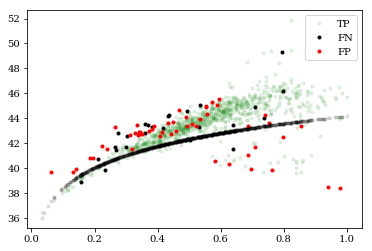

In [51]:
plt.plot(z_rescaled[TP_Ia], mu_from_mb[TP_Ia], '.g', label='TP', alpha=0.1)
plt.plot(z_rescaled[FN_Ia], mu_from_mb[FN_Ia], '.k', label='FN')
plt.plot(z_rescaled[FP_Ia], mu_from_mb[FP_Ia], '.r', label='FP')
#plt.plot(z_rescaled[TN_Ia], mu_from_mb[TN_Ia], '.c', label='TN')
plt.plot(z_rescaled, cosmo.distmod(z_rescaled), '.k', alpha=0.1)
plt.legend(loc='best')

(-2, 2)

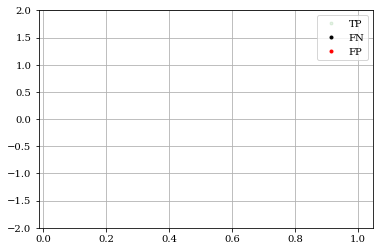

In [52]:
plt.plot(z_rescaled[TP_Ia], res_obs[TP_Ia], '.g', label='TP', alpha=0.1)
plt.plot(z_rescaled[FN_Ia], res_obs[FN_Ia], '.k', label='FN')
plt.plot(z_rescaled[FP_Ia], res_obs[FP_Ia], '.r', label='FP')
#plt.plot(z_rescaled[TN_Ia], mu_obs[TN_Ia], '.c', label='TN')
plt.legend(loc='best')
plt.grid()
plt.ylim(-2,2)

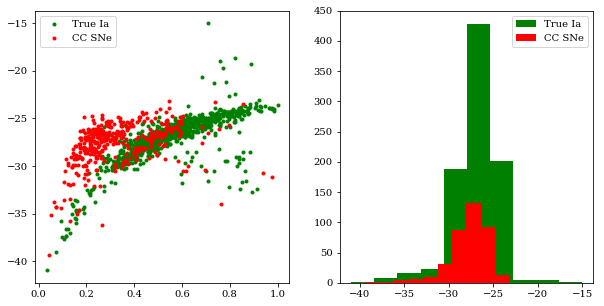

In [53]:
fig=plt.figure(1, figsize=(10,5))
plt.subplot(121)
plt.plot(z_rescaled[Y==1], mu_obs[Y==1], '.g', label='True Ia')
plt.plot(z_rescaled[Y!=1], mu_obs[Y!=1], '.r', label='CC SNe')
plt.legend(loc='best')
plt.subplot(122)
plt.hist(mu_obs[Y==1][~np.isnan(mu_obs[Y==1])], facecolor='g', label='True Ia')
plt.hist(mu_obs[Y!=1][~np.isnan(mu_obs[Y!=1])], facecolor='r', label='CC SNe')
plt.legend(loc='best')

(array([  22.,  118.,  153.,  183.,  227.,  215.,  162.,   95.,   60.,   20.]),
 array([ 0.034755 ,  0.1312815,  0.227808 ,  0.3243345,  0.420861 ,
         0.5173875,  0.613914 ,  0.7104405,  0.806967 ,  0.9034935,  1.00002  ]),
 <a list of 10 Patch objects>)

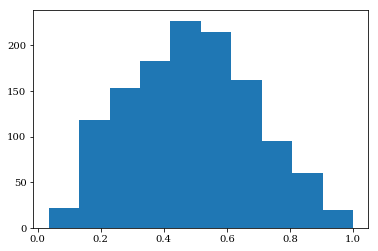

In [54]:
plt.hist(z_rescaled)

In [55]:
data_results=np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/DES_UNBLIND_KEY/DES_UNBLIND+HOSTZ.KEY'\
                           , dtype=None, names=True)

In [56]:
mypath='/Users/mariavincenzi/PhD/SNChallenge/DES_BLIND+HOSTZ/'
cid_list=[]
mu_theor=[]
for i in des_file_associated:
    try:
        read_file=open(mypath+i)
        read_file.readline()
        cid=int(((read_file.readline()).replace('SNID:','')).replace('\n',''))
        cid_list.append(cid)
        ind_data_res=np.where(data_results['CID']==cid)[0][0]
        mu_theor.append(data_results['MU'][ind_data_res])
    except IOError:
        mu_theor.append(np.nan)


Text(0,0.5,u'TRUE_z - S2z')

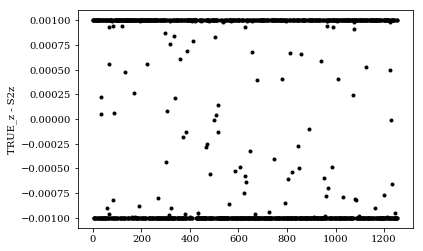

In [57]:
plt.plot(np.array(feats[:,2],dtype=float)-np.array(feats[:,26],dtype=float), '.k')
plt.ylabel('TRUE_z - S2z')

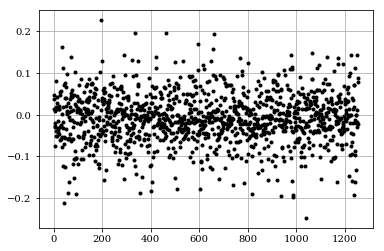

In [58]:
plt.plot(np.array(feats[:,2],dtype=float)-np.array(feats[:,16],dtype=float), '.k')
plt.grid()

In [59]:
#salt2_fit_train_sample_complete_tighterz
feats_zerr001 = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete.txt', dtype='str', comments='#')[:200]
feats_zerr0001 = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete_tighterz.txt', dtype='str', comments='#')


(-0.05, 0.05)

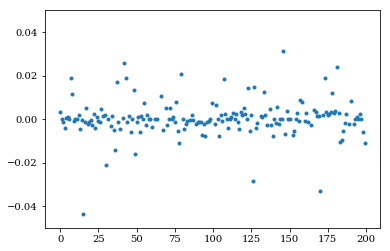

In [60]:
plt.plot(np.array(feats_zerr001[:,32], dtype=float)-np.array(feats_zerr0001[:,32], dtype=float), '.')
plt.ylim(-0.05, 0.05)


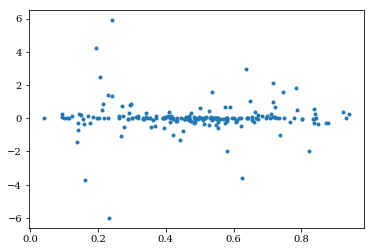

In [61]:
plt.plot(np.array(feats_zerr001[:,2], dtype=float), \
         np.array(feats_zerr001[:,22], dtype=float)-np.array(feats_zerr0001[:,32], dtype=float), '.')
#plt.ylim(-0.05, 0.05)

(array([    20.,    707.,  11292.,   4115.,   1632.,    856.,    470.,
           321.,    212.,    131.]),
 array([ -9.    ,  -2.5411,   3.9178,  10.3767,  16.8356,  23.2945,
         29.7534,  36.2123,  42.6712,  49.1301,  55.589 ]),
 <a list of 10 Patch objects>)

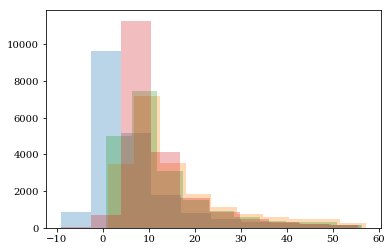

In [62]:
plt.hist(data_results['SNRMAX_g'], alpha=0.3)
plt.hist(data_results['SNRMAX_r'], alpha=0.3)
plt.hist(data_results['SNRMAX_i'], alpha=0.3)
plt.hist(data_results['SNRMAX_z'], alpha=0.3)

In [63]:
data_results

array([ ('SN:', 101953, 3, -9, 0.70257, 0.64937, 0.0329, 0, 52.5, -27.5, 0.0096593, 43.318, 56267.0, 28.067, 25.414, 24.871, 24.557, 1.9842, 3.7169, 4.5653, 7.8966, 7.8966, 4.5653, 3.7169, 0.0, 0.0, 93, -17.556, 49.436, 7.0504, 0.0, 2.1795, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0),
       ('SN:', 57351, 3, -9, 0.60522, 0.59962, 0.0257, 1, 34.5, -5.5, 0.022713, 42.923, 56230.0, 26.244, 23.898, 23.637, 23.287, 2.6373, 14.077, 19.227, 17.756, 19.227, 17.756, 14.077, 0.0, 0.0, 104, -14.304, 59.756, 6.2248, 0.0, 2.1796, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0),
       ('SN:', 31158, 3, -9, 0.7985, 0.7961, 0.0232, 0, 52.5, -27.5, 0.0096593, 43.658, 56239.0, 28.844, 26.18, 25.08, 24.897, 1.5084, 3.6698, 4.6915, 5.7629, 5.7629, 4.6915, 3.6698, 0.0, 0.0, 133, -15.886, 62.472, 6.6744, 0.0, 2.1794, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0),
       ...,
       ('SN:', 118986, 1, -9, 0.36586, 0.35556, 0.0326, 2, 36.75, -4.5, 0.028275, 41.618, 56358.0, 22.365, 21.583, 21.582, 22.031, 21.042, 42.238, 28.903, 17.656,

In [64]:
feats_withmb = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete.txt', dtype='str', comments='#')
feats_withmb.shape


(1256, 37)

In [65]:
mb=-2.5*np.log10(np.array(feats_withmb[:,36], dtype=float))
fake_mb= 30. -2.5*np.log10(np.array(feats_withmb[:,30], dtype=float))

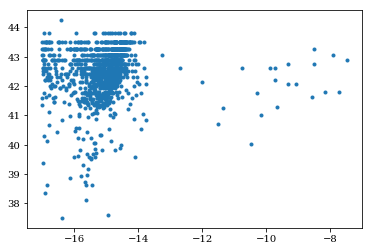

In [66]:
plt.plot(mb, fake_mb, '.')

In [ ]:
data_results=np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/DES_UNBLIND_KEY/DES_UNBLIND+HOSTZ.KEY'\
                           , dtype=None, names=True)



In [ ]:
### build a representative training sample
import random
feats_log10_TEST = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_TEST_sample_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]


feats_log10_REPRESENTATIVE = np.array([feats_log10_TEST[filter_nan][random.randint(0, len(feats_log10_TEST[filter_nan])-1)]\
                                       for j in range(1119)])

des_file_associated=feats_log10_REPRESENTATIVE[:,0]

In [ ]:

Y_TEST_REPR_results=[]
for des_snid in des_file_associated:
    try:
        CID=int((des_snid.replace('DES_SN','')).replace('.DAT',''))
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
        Y_TEST_REPR_results.append(data_results['GENTYPE'][ind_corrispondent][0])
    except ValueError:
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
#        print (ind_corrispondent, data_results['GENTYPE'][ind_corrispondent][0])
        print ('No type for', des_snid)
        Y_TEST_REPR_results.append(np.nan)


